In [5]:
import yfinance as yf 
import pandas as pd
from matplotlib import pylab as plt
import numpy as np
from datetime import datetime
import pandas_datareader.data as web
import quandl

## Price Label Prediction
Using classifier to predict sign of return one week ahead. Start with gold. 



In [333]:
HORIZON = 20

In [334]:
gold_tmp = quandl.get("LBMA/GOLD", authtoken="6rNSyTM5R4g7_B7XSyQW")
gold_tmp = gold_tmp['USD (AM)']




In [335]:
#gold_tmp = yf.download('SPY')
#gold_tmp = gold_tmp['Adj Close']

In [336]:
main_df = pd.DataFrame(gold_tmp.pct_change(HORIZON))
main_df.columns = ["ret"]
main_df['sign'] = np.where(main_df['ret']>0, 1, -1)
main_df['price'] = gold_tmp
main_df = main_df.dropna()


In [337]:
lookback = [5,10,21,31,63, 94]
vol_lookback = max(lookback)
vol = main_df['price'].rolling(vol_lookback).std()

for look in lookback:
    var_name = str(look) + '_' + str(4*look) + '_EMA'
    trend_tmp = main_df['price'].ewm(span=look).mean() - main_df['price'].ewm(span=4*look).mean()
    scld_trend = trend_tmp/vol
    trend_norm = scld_trend/scld_trend.rolling(252).std()
    trend_sig = (trend_norm * np.exp((-trend_norm**2)/4))/0.89
    main_df[var_name] = trend_sig
    
    
main_df['MA200'] = main_df['price']/main_df['price'].rolling(200).mean() - 1
main_df['MA50'] = main_df['price']/main_df['price'].rolling(50).mean() - 1
main_df['MA20'] = main_df['price']/main_df['price'].rolling(20).mean() - 1

### Prep data for model

In [338]:
ml_df = main_df.drop(['ret','price' ], axis=1)


ml_df = ml_df.dropna()
ml_df['sign'] = pd.Categorical(ml_df['sign']).shift(-HORIZON)


ml_df = ml_df[::HORIZON]
ml_df = ml_df.dropna()


#X_df = ml_df.drop('sign', axis = 1)
X_df = pd.DataFrame(ml_df[['MA200', 'MA50', 'MA20']])

Y_df = pd.DataFrame(ml_df['sign'])

In [339]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import shap

df_len = len(X_df)
x_train = X_df[:int(df_len*0.7)]
x_test = X_df[int(df_len*0.3):]

y_train = Y_df[:int(df_len*0.7)]
y_test = Y_df[int(df_len*0.3):]



In [340]:
rfc=RandomForestClassifier(random_state=42)


param_grid = { 
    'n_estimators': [200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [1,2,3],
    'criterion' :['gini', 'entropy']
}

CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5)
CV_rfc.fit(x_train, y_train.values.ravel())

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [1, 2, 3],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [200, 500]})

In [341]:
CV_rfc.best_params_

{'criterion': 'entropy',
 'max_depth': 3,
 'max_features': 'auto',
 'n_estimators': 200}

In [342]:
pred=CV_rfc.predict(x_test)

print("Accuracy for Random Forest on CV data: ",accuracy_score(y_test,pred))

Accuracy for Random Forest on CV data:  0.5772532188841202


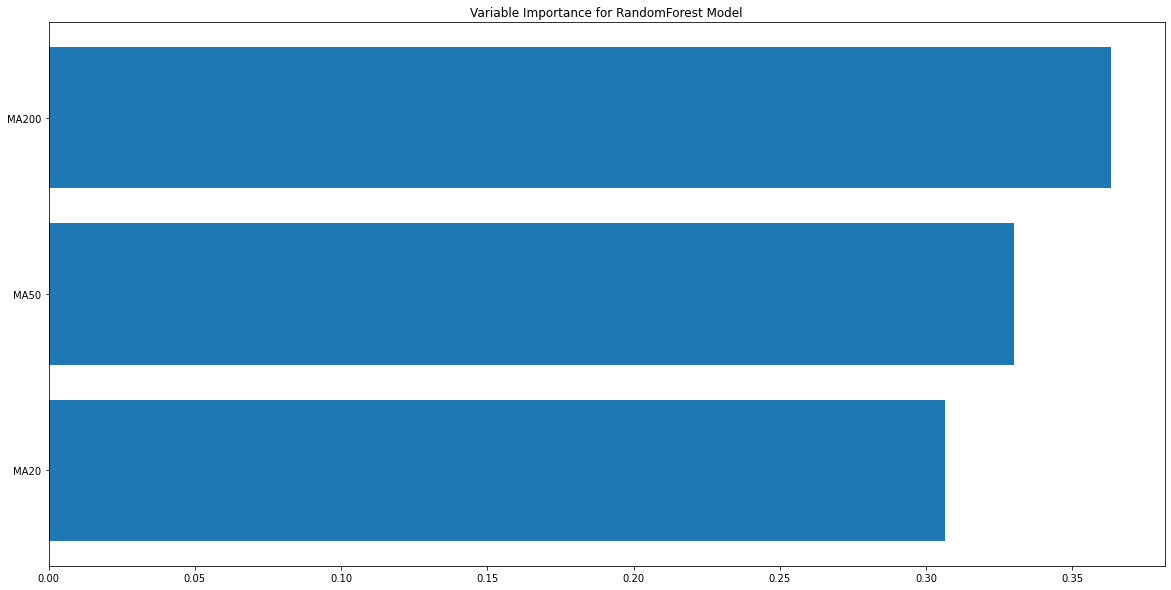

In [343]:
VIP_RF_df = pd.DataFrame(CV_rfc.best_estimator_.feature_importances_, index = x_train.columns).sort_values(0, ascending=True)    
plt.figure(figsize=(20,10));
plt.barh(VIP_RF_df.transpose().columns,VIP_RF_df.iloc[:, 0]);
plt.title('Variable Importance for RandomForest Model');

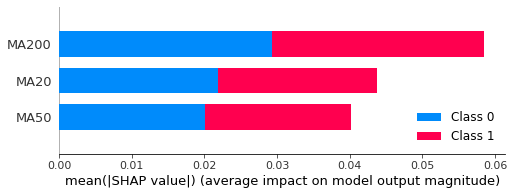

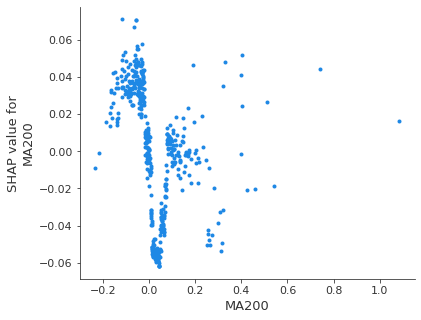

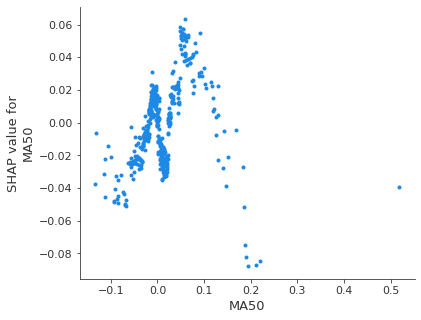

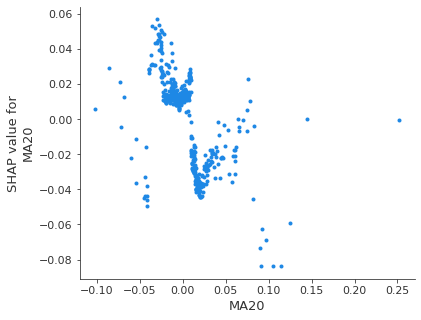

In [344]:
shap_values_ind_rf = shap.TreeExplainer(CV_rfc.best_estimator_).shap_values(x_train)

coeff_list =  x_train.columns.to_list()


explainer = shap.TreeExplainer(CV_rfc.best_estimator_)
shap_values = explainer.shap_values(x_train)

shap.summary_plot(shap_values_ind_rf,x_train)
for var in (range(len(coeff_list))):
    shap.dependence_plot(coeff_list[var], shap_values[0], x_train,interaction_index=None )